<a href="https://colab.research.google.com/github/disha2sinha/Movie-Recommendation-System/blob/master/Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORTING LIBRARIES:**

In [1]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
!pip install rake_nltk
from rake_nltk import Rake 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
#https://drive.google.com/file/d/1HcaON_5Qz-bfqlRyDgVWfdS4bD0hQ0Z3/view?usp=sharing

In [3]:
id='1HcaON_5Qz-bfqlRyDgVWfdS4bD0hQ0Z3'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('MoviesData.csv')  
movies_data = pd.read_csv('MoviesData.csv',engine='python',index_col=0)
movies_data.head()

,title,release_year,release_day,genres,original_language,runtime,content,production_companies,budget,revenue,profit,production_countries,status,popularity,vote_average,vote_count,movieId,cast,director,rating_count,mean_rating
0,Se7en,1995,Friday,Crime|Mystery|Thriller,English,127.0,Two homicide detectives are on a desperate hun...,New Line Cinema|Juno Pix|Cecchi Gori Pictures,33000000,327311859.0,294311859.0,United States of America,Released,18.457430,8.1,5915.0,47,Brad Pitt|Morgan Freeman|Gwyneth Paltrow|John ...,David Fincher,91921.0,4.052926
1,Batman,1989,Friday,Fantasy|Action,English,126.0,The Dark Knight of Gotham City begins his war ...,PolyGram Filmed Entertainment|The Guber-Peters...,35000000,411348924.0,376348924.0,United Kingdom|United States of America,Released,19.106730,7.0,2145.0,592,Jack Nicholson|Michael Keaton|Kim Basinger|Mic...,Tim Burton,91082.0,4.429015
2,The Empire Strikes Back,1980,Saturday,Adventure|Action|Science Fiction,English,124.0,"The epic saga continues as Luke Skywalker, in ...",Lucasfilm|Twentieth Century Fox Film Corporation,18000000,538400000.0,520400000.0,United States of America,Released,19.470959,8.2,5998.0,1196,Mark Hamill|Harrison Ford|Carrie Fisher|Billy ...,Irvin Kershner,87901.0,4.169975
3,Drag Me to Hell,2009,Sunday,Horror|Thriller,English,99.0,After denying a woman the extension she needs ...,Universal Pictures|Ghost House Pictures|Mandat...,30000000,90810892.0,60810892.0,United States of America,Released,15.809588,6.2,995.0,68952,Alison Lohman|Justin Long|Lorna Raver|Dileep R...,Sam Raimi,84078.0,4.152246
4,Suspect,1987,Friday,Crime|Drama|Thriller,English,121.0,When a Supreme Court judge commits suicide and...,TriStar Pictures,8000000,18782400.0,10782400.0,United States of America,Released,10.638289,6.4,45.0,4332,Cher|Dennis Quaid|Liam Neeson|John Mahoney|Joe...,Peter Yates,77960.0,4.154098


# **POPULARITY BASED RECOMMENDATION SYSTEM :**

In [4]:
movies_data[['vote_count','vote_average','rating_count','mean_rating','popularity']].describe()

,vote_count,vote_average,rating_count,mean_rating,popularity
count,45663.000000,45663.000000,45663.000000,45663.000000,45663.000000
mean,109.588179,5.617947,484.200666,0.771628,2.922354
std,490.228641,1.924399,2943.748802,1.389116,5.996711
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,5.000000,0.000000,0.000000,0.386454
50%,10.000000,6.000000,0.000000,0.000000,1.129126
75%,34.000000,6.800000,0.000000,0.000000,3.685682
max,14075.000000,10.000000,91921.000000,5.000000,547.488298


**WEIGHTED AVERAGE FOR EACH MOVIES AVERAGE RATINGS :**

Weighted Ratings: 
>              W =   Rv + Cm
>                   ---------
                     v+m

R= average rating for the movie as a number from 0 to 10

v= number of votes for the movie

m= minimum votes required to be listed in Top(here 2000)

C=the mean vote across whole report


In [5]:
R=movies_data['vote_average']
v=movies_data['vote_count']
C=movies_data['vote_average'].mean()
m=2000

In [6]:
movies_data['weighted_votes']=(R*v+C*m)/(v+m)
movies_data[['title','weighted_votes']].sort_values('weighted_votes',ascending=False).head(20)

,title,weighted_votes
67,The Shawshank Redemption,7.943512
1555,The Dark Knight,7.924073
2120,Fight Club,7.840666
2130,Pulp Fiction,7.797272
6075,Inception,7.791191
9040,The Godfather,7.781642
33564,Interstellar,7.723561
109,Forrest Gump,7.691071
2594,The Lord of the Rings: The Return of the King,7.614560
1942,The Lord of the Rings: The Fellowship of the Ring,7.562605


In [7]:
R1=movies_data['mean_rating']
v1=movies_data['rating_count']
C1=movies_data['mean_rating'].mean()
m1=movies_data['rating_count'].quantile(0.95)
m1

1643.9000000000015

In [8]:
movies_data['weighted_ratings']=(R1*v1+C1*m1)/(v1+m1)
movies_data[['title','weighted_ratings']].sort_values('weighted_ratings',ascending=False).head(20)

,title,weighted_ratings
1,Batman,4.364174
19,Three Days of the Condor,4.239907
15,Maze Runner: The Scorch Trials,4.204964
7,Dracula Untold,4.183633
13,Far from Heaven,4.138506
63,The Truman Show,4.113689
2,The Empire Strikes Back,4.107587
47,Street Kings,4.092986
3,Drag Me to Hell,4.087415
4,Suspect,4.084247


**ASSIGNING SCORES TO THE MOVIES BY GIVING 45% IMPORTANCE TO WEIGHTED AVERAGE OF VOTES + 45% IMPORTANCE TO POPULARITY + 10% TO WEIGHTED AVERAGE OF RATINGS**

In [9]:
scaler=MinMaxScaler()
movies_data[['weighted_votes','weighted_ratings','popularity']]=scaler.fit_transform(movies_data[['weighted_votes','weighted_ratings','popularity']])
movies_data['score']=movies_data['weighted_votes']*0.45 + movies_data['weighted_ratings']*0.1+movies_data['popularity']*0.45
movies_data[['title','weighted_votes','weighted_ratings','popularity','score']].sort_values('score',ascending=False).head(10)

,title,weighted_votes,weighted_ratings,popularity,score
27517,Minions,0.404024,0.000274,1.000000,0.631838
9,Wonder Woman,0.599344,0.846461,0.537613,0.596277
1555,The Dark Knight,0.993477,0.356847,0.224968,0.583985
2130,Pulp Fiction,0.950925,0.375564,0.257449,0.581325
67,The Shawshank Redemption,1.000000,0.757741,0.094332,0.568223
1609,Big Hero 6,0.775159,0.377674,0.390602,0.562360
116,Guardians of the Galaxy Vol. 2,0.690749,0.807078,0.338511,0.543875
328,Deadpool,0.728643,0.580056,0.343132,0.540304
131,Beauty and the Beast,0.510901,0.645611,0.524675,0.530570
1218,Gone Girl,0.794494,0.454052,0.282748,0.530164


**ONLY MOVIES HAVING SCORE ABOVE A THRESHOLD VALUE CONSIDERED POPULAR :**

In [10]:
movies_data.score.describe()

count    45663.000000
mean         0.110041
std          0.030936
min          0.030931
25%          0.099160
50%          0.100148
75%          0.104319
max          0.631838
Name: score, dtype: float64

In [11]:
movies_data[movies_data['score']>=0.0992].movieId.count()

33593

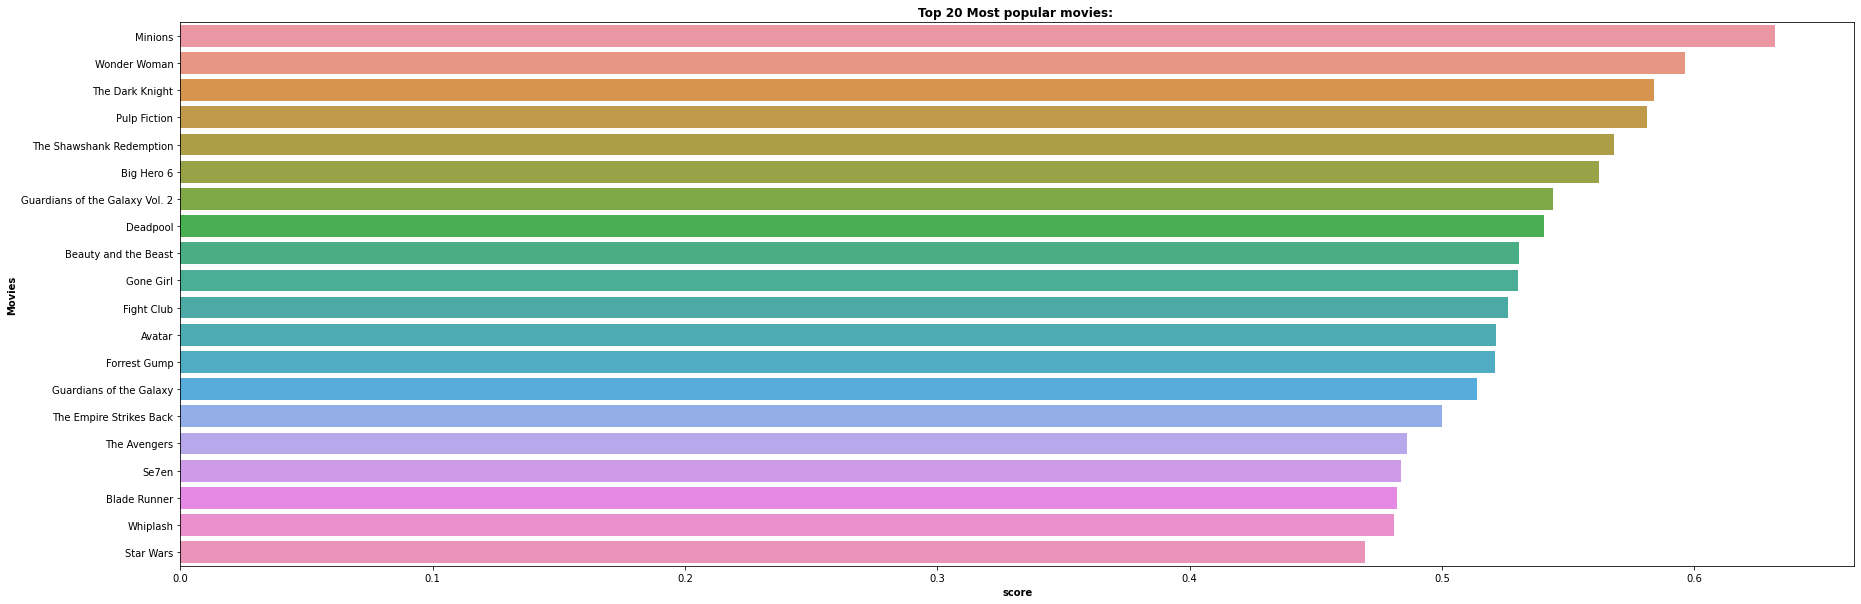

In [12]:
popular_movies=movies_data[movies_data['score']>=0.0992]
popular_movies=popular_movies[['movieId','title','budget','profit','score','release_year','release_day','genres','production_countries','production_companies','original_language','runtime','content','status','cast','director']].sort_values('score',ascending=False).reset_index(drop=True)
plt.figure(figsize=(30,10))
axis=sns.barplot(x=popular_movies['score'].head(20),y=popular_movies['title'].head(20))
plt.title('Top 20 Most popular movies: ',weight='bold')
plt.xlabel('score',weight='bold')
plt.ylabel('Movies',weight='bold')
plt.savefig('PopularMovies.jpg')

In [13]:
popular_movies.shape

(33593, 16)

In [14]:
popular_movies.head()

,movieId,title,budget,profit,score,release_year,release_day,genres,production_countries,production_companies,original_language,runtime,content,status,cast,director
0,135887,Minions,74000000,1.082731e+09,0.631838,2015,Wednesday,Family|Animation|Adventure|Comedy,United States of America,Universal Pictures|Illumination Entertainment,English,91.0,"Minions Stuart, Kevin and Bob are recruited by...",Released,Sandra Bullock|Jon Hamm|Michael Keaton|Allison...,Kyle Balda
1,143355,Wonder Woman,149000000,6.715804e+08,0.596277,2017,Tuesday,Action|Adventure|Fantasy,United States of America,Dune Entertainment|Atlas Entertainment|Warner ...,English,141.0,An Amazon princess comes to the world of Man t...,Released,Gal Gadot|Chris Pine|Robin Wright|Danny Huston...,Patty Jenkins
2,58559,The Dark Knight,185000000,8.195584e+08,0.583985,2008,Wednesday,Drama|Action|Crime|Thriller,United Kingdom|United States of America,DC Comics|Legendary Pictures|Warner Bros.|DC E...,English,152.0,Batman raises the stakes in his war on crime. ...,Released,Christian Bale|Michael Caine|Heath Ledger|Aaro...,Christopher Nolan
3,296,Pulp Fiction,8000000,2.059288e+08,0.581325,1994,Saturday,Thriller|Crime,United States of America,Miramax Films|A Band Apart|Jersey Films,English,154.0,"A burger-loving hit man, his philosophical par...",Released,John Travolta|Samuel L. Jackson|Uma Thurman|Br...,Quentin Tarantino
4,318,The Shawshank Redemption,25000000,3.341469e+06,0.568223,1994,Friday,Drama|Crime,United States of America,Castle Rock Entertainment|Warner Bros.,English,142.0,Framed in the 1940s for the double murder of h...,Released,Tim Robbins|Morgan Freeman|Bob Gunton|Clancy B...,Frank Darabont


**IMPORTING USER_RATINGS DATASET:**

In [15]:
#https://drive.google.com/file/d/1nVaAmYBm8xnDR8ynF9eX0qY06_c5ZzqG/view?usp=sharing
id='1nVaAmYBm8xnDR8ynF9eX0qY06_c5ZzqG'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('RevisedRatings.csv')  
user_ratings = pd.read_csv('RevisedRatings.csv',engine='python',index_col=0)
user_ratings.head()

,userId,movieId,rating
0,1,110,1.0
1,1,147,4.5
2,1,858,5.0
3,1,1221,5.0
4,1,1246,5.0


**FILTERING USERS BY THE NUMBER OF RATINGS THEY GAVE:**Users who gave less than 60 ratings are discarded.

In [16]:
user_numberOfRatings=pd.DataFrame(user_ratings.groupby('userId')['rating'].count()).rename(columns={'rating':'count_rating'})
user_numberOfRatings=user_numberOfRatings[user_numberOfRatings['count_rating']>50]
len(user_numberOfRatings)

102379

In [17]:
user_ratings.shape

(26024289, 3)

In [18]:
users_movies=pd.merge(user_ratings,popular_movies[['movieId','title']],how='inner',on='movieId')
selectedusers=user_numberOfRatings.index.values.tolist()
final_ratings=users_movies.query('userId in @selectedusers')
final_ratings.shape

(22332746, 4)

In [19]:
final_ratings.head()

,userId,movieId,rating,title
1,11,110,3.5,Braveheart
3,24,110,5.0,Braveheart
4,29,110,3.0,Braveheart
5,30,110,5.0,Braveheart
7,34,110,5.0,Braveheart


# **CONTENT - BASED RECOMMENDATION SYSTEM ON POPULAR MOVIES**

In [20]:
popular_movies['keywords']=popular_movies['cast'].apply(str)+" "+popular_movies['production_companies'].apply(str)+" "+popular_movies['production_countries'].apply(str)+" "+popular_movies['content'].apply(str)+" "+popular_movies['genres'].apply(str)+" "+popular_movies['director'].apply(str)+" "+popular_movies['release_day'].apply(str)+" "+popular_movies['release_year'].apply(str)+" "+popular_movies['budget'].apply(str)+" "+popular_movies['profit'].apply(str)+" "+popular_movies['score'].apply(str)+" "+popular_movies['runtime'].apply(str)+" "+popular_movies['status'].apply(str)+" "+popular_movies['original_language'].apply(str)
popular_movies['important_words']=""
for index,row in popular_movies.iterrows():
  keywords=row['keywords']
  r=Rake()
  r.extract_keywords_from_text(keywords)
  keywords_scores=r.get_word_degrees()
  popular_movies.at[index,'important_words']=list(keywords_scores.keys())


In [21]:
popular_movies['important_words']=[','.join(map(str,word)) for word in popular_movies['important_words']]
popular_movies.head()

,movieId,title,budget,profit,score,release_year,release_day,genres,production_countries,production_companies,original_language,runtime,content,status,cast,director,keywords,important_words
0,135887,Minions,74000000,1.082731e+09,0.631838,2015,Wednesday,Family|Animation|Adventure|Comedy,United States of America,Universal Pictures|Illumination Entertainment,English,91.0,"Minions Stuart, Kevin and Bob are recruited by...",Released,Sandra Bullock|Jon Hamm|Michael Keaton|Allison...,Kyle Balda,Sandra Bullock|Jon Hamm|Michael Keaton|Allison...,"scarlet,overkill,gru,sandra,bullock,world,dave..."
1,143355,Wonder Woman,149000000,6.715804e+08,0.596277,2017,Tuesday,Action|Adventure|Fantasy,United States of America,Dune Entertainment|Atlas Entertainment|Warner ...,English,141.0,An Amazon princess comes to the world of Man t...,Released,Gal Gadot|Chris Pine|Robin Wright|Danny Huston...,Patty Jenkins,Gal Gadot|Chris Pine|Robin Wright|Danny Huston...,"wisdom,betty,adewole,fred,fergus,ooooota,adepo..."
2,58559,The Dark Knight,185000000,8.195584e+08,0.583985,2008,Wednesday,Drama|Action|Crime|Thriller,United Kingdom|United States of America,DC Comics|Legendary Pictures|Warner Bros.|DC E...,English,152.0,Batman raises the stakes in his war on crime. ...,Released,Christian Bale|Michael Caine|Heath Ledger|Aaro...,Christopher Nolan,Christian Bale|Michael Caine|Heath Ledger|Aaro...,"daniel,jefferson,lorna,gayle,tommy,campbell,ri..."
3,296,Pulp Fiction,8000000,2.059288e+08,0.581325,1994,Saturday,Thriller|Crime,United States of America,Miramax Films|A Band Apart|Jersey Films,English,154.0,"A burger-loving hit man, his philosophical par...",Released,John Travolta|Samuel L. Jackson|Uma Thurman|Br...,Quentin Tarantino,John Travolta|Samuel L. Jackson|Uma Thurman|Br...,"forth,moll,frank,whaley,duane,whitaker,burger,..."
4,318,The Shawshank Redemption,25000000,3.341469e+06,0.568223,1994,Friday,Drama|Crime,United States of America,Castle Rock Entertainment|Warner Bros.,English,142.0,Framed in the 1940s for the double murder of h...,Released,Tim Robbins|Morgan Freeman|Bob Gunton|Clancy B...,Frank Darabont,Tim Robbins|Morgan Freeman|Bob Gunton|Clancy B...,"hope,jones,clancy,brown,alfonso,freeman,j,doro..."


In [ ]:
cv=CountVectorizer()
count_matrix=cv.fit_transform(popular_movies[popular_movies['title']!='Minions']['important_words'])
cosine_sim=cosine_similarity(count_matrix,count_matrix)
cosine_sim